# Appendix XX - Multiple promoter model

In [11]:
# For operating system interaction
import os
import glob
import datetime
import sys
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special
from tqdm import tqdm

# To perform MCMC
import pymc3 as pm
import theano.tensor as tt

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

#### $\LaTeX$ commands
$\newcommand{\foldchange}{\text{fold-change}}$
$\newcommand{\mm}{\left\langle m \right\rangle}$
$\newcommand{\Nns}{N_{NS}}$
$\newcommand{\Ns}{N_{S}}$
$\newcommand{\pact}{p_{\text{act}}}$
$\newcommand{\Rs}{\left\langle R_S \right\rangle}$
$\newcommand{\Rns}{\left\langle R_{NS} \right\rangle}$
$\newcommand{\Rt}{\left\langle R_{\text{tot}} \right\rangle}$
$\newcommand{\eRA}{\Delta\varepsilon_{RA}}$

We will explore the fact that during the
cell cycle cells at the growth rate that we perform our experiments will have
up to two copies of the reporter gene. For this scenario we can explore two possibilities:
- The case in which both promoters are independent of each other.
- The case in which the connection between both promoters due to a shared
  transcription factor pool is explicitly accounted for.

In this notebook we will focus on the latter case in which both copies of the promoters are entangled via the shared transcription factor pool.

We begin by defining $1 - f$ as the fraction of the time during the cell cycle
in which cells have only one copy of the reporter gene. This implies that $f$ is
the fraction of the time that cells spend with two copies of the gene.

When we relax the promoters independence assumption we can use the grand
canonical ensemble formulation. In this
description the fold-change equation is given by
\begin{equation}
  \foldchange = {1 \over 1 + \lambda_r e^{-\beta\Delta\varepsilon_{RA}}},
  \tag{1}
\end{equation}
where $\lambda_r$ is the fugacity of the repressor. The value of this fugacity
is obtained by taking into account all of the repressor reservoirs considered in
the system. In our case there are two repressor reservoirs: repressors bound to
specific binding sites $\Rs$ and repressors bound to non-specific binding sites
$\Rns$. These two reservoirs are connected through the constraint
\begin{equation}
  \Rt = \Rs + \Rns,
  \tag{2}
\end{equation}
where $\Rt$ is the repressor copy number as determined by an independent
method. The repressor reservoir expressions are given by
\begin{equation}
  \Rs = \Ns {\lambda_r e^{-\beta\eRA} \over 1 + \lambda_r e^{-\beta\eRA}},
  \tag{3}
\end{equation}
and
\begin{equation}
  \Rns = \Nns {\lambda_r \over 1 + \lambda_r},
  \tag{4}
\end{equation}
where $\Ns$ is the number of specific binding sites for the repressor, i.e. the
number of promoters, and $\Nns$ is the number of non-specific binding sites.

Since $\Rt$ is measured using independent methods we can constrain the value
of $\lambda_r$ using Eq. (2) in combination with Eq. (3) and
Eq. (4). This is
\begin{equation}
  \Rt = \Ns {\lambda_r e^{-\beta\eRA} \over 1 + \lambda_r e^{-\beta\eRA}} +
  \Nns {\lambda_r \over 1 + \lambda_r}.
  \tag{5}
\end{equation}
Distributing terms gives a second order polynomial on $\lambda_r$ of the form
\begin{equation}
  \lambda_r^2 e^{-\beta\eRA} (\Rt - \Ns - \Nns) +
  \lambda_r (\Rt + \Rt e^{-\beta\eRA} - \Ns e^{-\beta\eRA} - \Nns) +
  \Rt = 0.
  \tag{6}
\end{equation}

For the quadratic term in $\lambda_r$ we note that $\Nns \gg \Rt, \Ns$,
therefore we can approximate it as
\begin{equation}
  \lambda_r^2 e^{-\beta\eRA} (\Rt - \Ns - \Nns) \approx
  \lambda_r^2 e^{-\beta\eRA} \Nns.
  \tag{7}
\end{equation}

For the linear term on $\lambda_r$ only the terms $\Rt e^{-\beta\eRA})$ and
$\Ns e^{-\beta\eRA}$ are of the same order of magnitude as $\Nns$, so we have
\begin{equation}
  \lambda_r (\Rt + \Rt e^{-\beta\eRA} - \Ns e^{-\beta\eRA} - \Nns) \approx
  \lambda_r \left[ e^{-\beta\eRA} \left(\Rt  - \Ns \right)  - \Nns \right].
  \tag{8}
\end{equation}
With these simplifications in hand is a matter of finding the positive root of
this second order polynomial to obtain the value for the fugacity.

Using this formulation the mean mRNA copy number is then given by
\begin{equation}
  \mm = (1 - f) \mm_1 + f \mm_2.
  \tag{9}
\end{equation}

If we assume that having two copies of the promoter produces twice as much
as one promoter this is given by
\begin{equation}
  \mm = (1 - f) {r \over \gamma} \times \foldchange(\Ns = 1) +
  f {(2r) \over \gamma} \times \foldchange(\Ns = 2),
  \tag{10}
\end{equation}
where we explicitly state that the fold-change function depends on the number
of specific binding sites.

For the fold-change equation of the total mean number of mRNA we then have
\begin{equation}
  \foldchange =
  { {r \over \gamma} \left[ (1 - f) \times \foldchange(Ns = 1) +
  2 f \times \foldchange(\Ns=2) \right]
  \over
  {r \over \gamma} \left[ (1 - f) + 2 f \right].
  }
  \tag{11}
\end{equation}
When substituting the definition of fold-change we obtain our final expression
\begin{equation}
  \foldchange = {1 \over (1 + f)} \left[
  (1 - f) {1 \over 1 + {R \over \Nns} e^{-\beta\eRA}} +
  2 f {1 \over 1 + \lambda_r e^{-\beta\eRA}} \right].
  \tag{12}
\end{equation}

# Testing the two promoter model with reported parameters.

Our first approach to test Eq. (12) will be to use the usual parameters. For the *galK* locus we have that the cell has on average $\approx 1.8$ copies of the gene. This implies that it must be true that
$$
(1 - f) \times 1 + f \times 2 = 1.8.
\tag{13}
$$
Solving for $f$ gives that $f = 1.8 - 1 = 0.8$.

So using the usual parameters and this new parameter let's find what this model does for the fold-change predictions.

We will start by defining a function that computes Eq. (12).

In [2]:
def fold_change_double(R, iptg, epsilon_r, 
                       f=.8, ea=-np.log(139), ei=-np.log(0.53), epsilon=4.5,
                       Ns=2, Nns=4.6E6):
    '''
    Computes the fold-change for a promoter that spends f fraction of the time
    with two copies of the promoter and (1-f) with one promoter.
    Parameters
    ----------
    R : array-like.
        Number of repressors per cell.
    iptg : array-like.
        Inducer concentration.
    epsilon_r : float.
        Repressor-DNA binding energy.
    f : float.
        Fraction of the cell cycle that the cell spends with multiple copies of
        the promoter.
    ea, ei : float.
        -log(Ka) and -log(Ki) respectively.
    epsilon : float.
        Energy difference between active and inactive state of repressor.
    Ns : int.
        Number of promoters that the cell has f fraction of the time.
    Nns : int.
        Number of non-specific binding sites

    Returns
    -------
    fold_change : array-like.
        fold-change in gene expression.
    '''
    
    # Compute the number of active repressors
    Ract = mwc.pact_log(iptg=iptg, ea=ea, ei=ei, epsilon=epsilon) * R
    
    # Define the coefficients of the polynomial
    a = -2 * Nns * np.exp(-epsilon_r)
    b = np.exp(-epsilon_r) * (Ract - Ns) - 2 * Nns
    c = Ract
    
    # Initialize array to save
    lam = np.empty_like(Ract)
    # Find the value of lambda
    for i, r in enumerate(Ract):
        lam[i] = np.max(np.roots([a, b[i], c[i]]))
    
    # Compute and return fold-change
    single_fc = 1 / (1 + Ract / Nns * np.exp(-epsilon_r))
    double_fc = 1 / (1 + lam * np.exp(-epsilon_r))
    fold_change = 1 / (1 + f) * ((1 - f) * single_fc + 2 * f * double_fc)
                 
    return fold_change

Now let's load the experimental data used in the main text.

In [3]:
# Define working directory
datadir = '../../data/'
# List files to be read
files = ['flow_master.csv', 'merged_Oid_data_foldchange.csv']
# Read flow cytometry data
df_Oid = pd.read_csv(datadir + files[1], comment='#')
# make an extra column to have consistent labeling
df_Oid['fold_change_A'] = df_Oid.fold_change
# Remove manually the outlier with an unphysical fold-change
df_Oid = df_Oid[df_Oid.fold_change_A <= 1]
# Read the flow cytometry data
df = pd.read_csv(datadir + files[0], comment='#')
# Attach both data frames into a single one
df = pd.concat([df, df_Oid])
# Drop rows containing NA values
df.dropna(axis=1, inplace=True)
# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]
df.head()

,IPTG_uM,binding_energy,date,fold_change_A,operator,rbs,repressors,username
2,0.0,-13.9,20160804,0.007146,O2,RBS1L,870,mrazomej
3,0.0,-13.9,20160804,0.006847,O2,RBS1,610,mrazomej
4,0.0,-13.9,20160804,0.013059,O2,RBS1027,130,mrazomej
5,0.0,-13.9,20160804,0.021853,O2,RBS446,62,mrazomej
6,0.0,-13.9,20160804,0.041988,O2,RBS1147,30,mrazomej


To have the correct $K_A$ and $K_I$ values we will now import the MCMC chains

In [4]:
# Load the flat-chain
with open('../../data/mcmc/main_text_KaKi.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
ea, ei, sigma = gauss_flatchain[max_idx]

We will now plot the comparison between the single promoter model (solid lines) vs. Eq. (12) (doted lines).

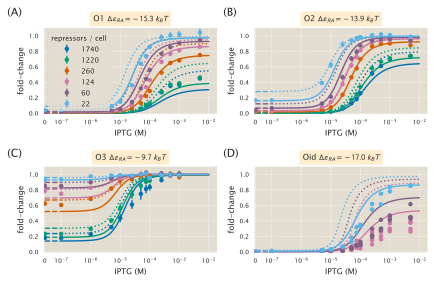

In [5]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-7, -2, 100)
IPTG_lin = np.array([0, 1E-7])

# Define parameters for the multi-promoter model
f = 0.8
Ns = 2

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O1', 'O2', 'O3', 'Oid']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17.0}

# Initialize the plot to set the size
fig, ax = plt.subplots(2, 2, figsize=(6, 4))
ax = ax.ravel()

# Loop through operators
for i, op in enumerate(operators):
    data = df[df.operator == op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
        # Check if the RBS was measured for this operator
        if rbs in data.rbs.unique():
            # plot the theory using the parameters from the fit.
            # SINGLE PROMOTER
            # Log scale
            ax[i].plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
                                                 ea=ea,
                                                 ei=ei,
                                                 epsilon=4.5,
                                R=data[(data.rbs == rbs)].repressors.unique(),
                                                 epsilon_r=energies[op]),
                       color=colors[j])
            # Linear scale
            ax[i].plot(IPTG_lin, mwc.fold_change_log(IPTG_lin * 1E6,
                       ea=ea, ei=ei, epsilon=4.5,
                                R=df[(df.rbs == rbs)].repressors.unique(),
                epsilon_r=energies[op]),
                color=colors[j], linestyle='--')
            
            # MULTIPLE PROMOTERS
            # Log scale
            ax[i].plot(IPTG, fold_change_double(iptg=IPTG * 1E6, f=f, Ns=Ns,
                                                ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique() * 2,
            epsilon_r=energies[op]),
                       color=colors[j], linestyle=':')
            # Linear scale
            ax[i].plot(IPTG_lin, fold_change_double(iptg=IPTG_lin * 1E6, f=f,
                                                    Ns=Ns, ea=ea, ei=ei,
                                                    epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique() * 2,
            epsilon_r=energies[op]),
                color=colors[j], linestyle='--')

        # Plot mean and standard error of the mean for the flow data
        if op != 'Oid':
            # compute the mean value for each concentration
            fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
            # compute the standard error of the mean
            fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
            np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())

            # plot the experimental data
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                           fc_mean, yerr=fc_err, fmt='o',
                label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                color=colors[j], markersize=4.5)
        # Plot the raw data for Oid
        else:
            ax[i].plot(data[data.rbs==rbs].IPTG_uM / 1E6,
                    data[data.rbs==rbs].fold_change_A, marker='o', lw=0,
                    color=colors[j], markersize=4.5)

    # Plot labels
    ax[i].set_title(r'%s $\Delta \varepsilon_{RA}= %0.1f\ k_BT$' % (
        op, energies[op]), backgroundcolor='#FFEDCE', y=1.01,
        fontsize=7)
    # Arrange axis
    ax[i].set_xscale('symlog', linthreshx=1E-7, linscalex=0.5)
    ax[i].set_xlabel('IPTG (M)', fontsize=15)
    ax[i].set_ylabel('fold-change', fontsize=16)
    ax[i].set_ylim([-0.01, 1.1])
    ax[i].set_xlim(left=-5E-9)
    ax[i].tick_params(labelsize=14)

ax[0].legend(loc='upper left', title='repressors / cell')
# add plot letter labels
plt.figtext(0.0, .95, '(A)', fontsize=11)
plt.figtext(0.50, .95, '(B)', fontsize=11)
plt.figtext(0.0, .46, '(C)', fontsize=11)
plt.figtext(0.50, .46, '(D)', fontsize=11)
mwc.scale_plot(fig, 'two_row')
plt.tight_layout()

So far we have assumed that during the cell cycle the number of repressors
remains constant along the cell cycle. To consider changes of repressor copy
number during the cell cycle we can assume that the fraction of time $(1 - f)$
is enough for the cell to double the number of available repressors. What this
implies is that the repressor copy number as determined with quantitative
westerns measured a mixture of two populations - $f$ fraction of the cells with
one copy of the *lacI* gene and $(1 - f)$ fraction of the cells with
two copies of the *lacI* gene -. Implementing this assumption implies
that the measured number of repressors $\langle R_{\text{western}}\rangle$ is
given by
\begin{equation}
  \langle R_{\text{western}}\rangle = (1 - f) \langle R \rangle +
  f (2 \times \langle R \rangle),
  \tag{14}
\end{equation}
where $\langle R \rangle$ is the mean repressor copy number for a single copy
of the *lacI* gene. Solving Eq. (14) for
$\langle R \rangle$ gives
\begin{equation}
  \langle R \rangle = { \langle R_{\text{western}}\rangle \over (1 + f)}.
  \tag{15}
\end{equation}

Let's now define a function that takes in to account this assumed variability during the cell cycle.

In [6]:
def fold_change_double_R_adjust(R, iptg, epsilon_r, f=0.8,
                                ea=-np.log(139), ei=-np.log(0.53),  epsilon=4.5,
                                Ns=2, Nns=4.6E6):
    '''
    Computes the fold-change for a promoter that spends f fraction of the time
    with two copies of the promoter and (1-f) with one promoter.
    '''
    
    # Compute the number of active repressors
    Ract = mwc.pact_log(iptg=iptg, ea=ea, ei=ei, epsilon=epsilon) * R
    
    Reff = Ract / (1 + f)
    
    # Define the coefficients of the polynomial
    a = -2 * Nns * np.exp(-epsilon_r)
    b = np.exp(-epsilon_r) * (2 * Reff - Ns) - 2 * Nns
    c = 2 * Reff
    
    # Initialize array to save
    lam = np.empty_like(Ract)
    # Find the value of lambda
    for i, r in enumerate(Ract):
        lam[i] = np.max(np.roots([a, b[i], c[i]]))
    
    # Compute and return fold-change
    single_fc = 1 / (1 + Reff / Nns * np.exp(-epsilon_r))
    double_fc = 1 / (1 + lam * np.exp(-epsilon_r))
    fold_change = 1 / (1 + f) * ((1 - f) * single_fc + 2 * f * double_fc)
                 
    return fold_change

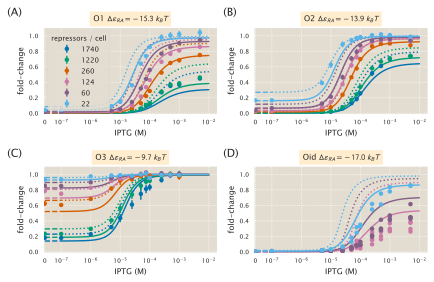

In [7]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-7, -2, 100)
IPTG_lin = np.array([0, 1E-7])

# Define parameters for the multi-promoter model
f = 0.8
Ns = 2

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O1', 'O2', 'O3', 'Oid']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17.0}

# Initialize the plot to set the size
fig, ax = plt.subplots(2, 2, figsize=(6, 4))
ax = ax.ravel()

# Loop through operators
for i, op in enumerate(operators):
    data = df[df.operator == op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
        # Check if the RBS was measured for this operator
        if rbs in data.rbs.unique():
            # plot the theory using the parameters from the fit.
            # SINGLE PROMOTER
            # Log scale
            ax[i].plot(IPTG, mwc.fold_change_log(IPTG * 1E6,
                                                 ea=ea,
                                                 ei=ei,
                                                 epsilon=4.5,
                                R=data[(data.rbs == rbs)].repressors.unique(),
                                                 epsilon_r=energies[op]),
                       color=colors[j])
            # Linear scale
            ax[i].plot(IPTG_lin, mwc.fold_change_log(IPTG_lin * 1E6,
                       ea=ea, ei=ei, epsilon=4.5,
                                R=df[(df.rbs == rbs)].repressors.unique(),
                epsilon_r=energies[op]),
                color=colors[j], linestyle='--')
            
            # MULTIPLE PROMOTERS
            # Log scale
            ax[i].plot(IPTG, fold_change_double_R_adjust(iptg=IPTG * 1E6, 
                                                         f=f, Ns=Ns,
                                                         ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique() * 2,
            epsilon_r=energies[op]),
                       color=colors[j], linestyle=':')
            # Linear scale
            ax[i].plot(IPTG_lin, fold_change_double_R_adjust(iptg=IPTG_lin * 1E6,
                                                             f=f, Ns=Ns, 
                                                             ea=ea, ei=ei,
                                                             epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique() * 2,
            epsilon_r=energies[op]),
                color=colors[j], linestyle='--')

        # Plot mean and standard error of the mean for the flow data
        if op != 'Oid':
            # compute the mean value for each concentration
            fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
            # compute the standard error of the mean
            fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
            np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())

            # plot the experimental data
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                           fc_mean, yerr=fc_err, fmt='o',
                label=df[df.rbs==rbs].repressors.unique()[0] * 2,
                color=colors[j], markersize=4.5)
        # Plot the raw data for Oid
        else:
            ax[i].plot(data[data.rbs==rbs].IPTG_uM / 1E6,
                    data[data.rbs==rbs].fold_change_A, marker='o', lw=0,
                    color=colors[j], markersize=4.5)

    # Plot labels
    ax[i].set_title(r'%s $\Delta \varepsilon_{RA}= %0.1f\ k_BT$' % (
        op, energies[op]), backgroundcolor='#FFEDCE', y=1.01,
        fontsize=7)
    # Arrange axis
    ax[i].set_xscale('symlog', linthreshx=1E-7, linscalex=0.5)
    ax[i].set_xlabel('IPTG (M)', fontsize=15)
    ax[i].set_ylabel('fold-change', fontsize=16)
    ax[i].set_ylim([-0.01, 1.1])
    ax[i].set_xlim(left=-5E-9)
    ax[i].tick_params(labelsize=14)

ax[0].legend(loc='upper left', title='repressors / cell')
# add plot letter labels
plt.figtext(0.0, .95, '(A)', fontsize=11)
plt.figtext(0.50, .95, '(B)', fontsize=11)
plt.figtext(0.0, .46, '(C)', fontsize=11)
plt.figtext(0.50, .46, '(D)', fontsize=11)
mwc.scale_plot(fig, 'two_row')
plt.tight_layout()

# Re-fitting $\eRA$ assuming the two promoter model.

Since there seems to be a big disagreement between the two promoter and the single promoter model we will refit the binding energy to the original Garcia & Phillips, 2011 data assuming Eq. (12).

Let's first import the data.

In [22]:
df = pd.read_csv('../../data/tidy_Garcia_2011_raw_data.csv')
df.dropna(axis=0, inplace=True)
df.head()

,rbs,integration_location,operator,mu_mean,mu_std,reporter,trial,fold_change,repressors,delta_repressors,binding_energy
0,RBS1,galK,Oid,1.434063,0.249168,lacZ,C:\Users\hgarcia\Documents\Research\Sequence D...,0.000221,610.0,80.0,-17.0
1,RBS1,galK,O1,7.302860,0.482712,lacZ,C:\Users\hgarcia\Documents\Research\Sequence D...,0.001294,610.0,80.0,-15.3
2,RBS1,galK,O2,35.097754,3.767175,lacZ,C:\Users\hgarcia\Documents\Research\Sequence D...,0.006133,610.0,80.0,-13.5
3,HG104,galK,Oid,43.403095,2.550718,lacZ,C:\Users\hgarcia\Documents\Research\Sequence D...,0.006691,11.0,2.0,-17.0
4,HG104,galK,O1,213.194120,8.565661,lacZ,C:\Users\hgarcia\Documents\Research\Sequence D...,0.037764,11.0,2.0,-15.3


Just as a reminder of how the data looks like, let's plot the raw data.

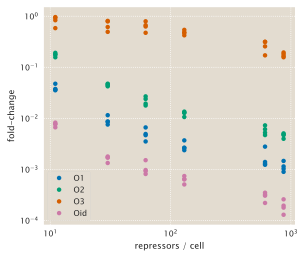

In [23]:
df_group = df.groupby('operator')

fig = plt.figure()
for group, data in df_group:
    plt.plot(data.repressors, data.fold_change, 'o', markersize=4.5, lw=0,
             label=group)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('repressors / cell')

fig.set_size_inches(4.5, 4)
plt.ylabel('fold-change')

### Using `PyMC3` to fit the energies.

As a way to get familiar with the package I will fit the $\eRA$ parameters to this data using the `PyMC3` package.

Let's define the relevant functions.

In [24]:
def jeffreys(val):
    return -tt.log(val)


def trace_to_df(trace, model):
    """
    Converts the trace from a pymc3 sampling trace to a
    Pandas DataFrame.
    """

    def compute_logp(chain):
        """
        Computes the log probability of the provided trace
        at a given chain.
        """
        names = trace.varnames
        var_dict = {}
        for n in names:
            var_dict[n] = trace.get_values(n, chains=chain)
        sample_df = pd.DataFrame(var_dict)

        logp = [model.logp(sample_df.iloc[step]
                           ) for step in range(len(sample_df))]
        return logp

    chains = trace.chains
    for c in tqdm(chains, desc='Processing chains'):
        logp = compute_logp(c)
        if c == 0:
            df = pm.trace_to_dataframe(trace, chains=c)
            df.insert(np.shape(df)[1], 'logp', logp)
        else:
            _df = pm.trace_to_dataframe(trace, chains=c)
            _df.insert(np.shape(_df)[1], 'logp', logp)
            df.append(_df, ignore_index=True)

    return df


def compute_statistics(df, ignore_vars='logp'):
    """
    Computes the mode and highest probability density (hpd)
    of the parameters in a given dataframe.  """  # Set up the multi indexing.
    var_names = np.array(df.keys())
    if ignore_vars is not None:
        var_names = var_names[var_names != ignore_vars]

    # Generate arrays for indexing and zip as tuples.
    names = [var for var in var_names] * 3
    stats = ['mode', 'hpd_min', 'hpd_max']
    stats = np.array([[s] * len(var_names) for s in stats]).flatten()
    tuples = list(zip(*[names, stats]))

    # Define the index.
    index = pd.MultiIndex.from_tuples(tuples, names=['var', 'stat'])

    # Determine the mode for each
    mode_ind = np.argmax(df['logp'])
    stat_vals = [df.iloc[mode_ind][var] for var in var_names]
    # Compute the min and max vals of the HPD.
    hpd_min, hpd_max = [], []
    for i, var in enumerate(var_names):
        _min, _max = mwc.hpd(df[var], 0.95)
        hpd_min.append(_min)
        hpd_max.append(_max)
    for _ in hpd_min:
        stat_vals.append(_)
    for _ in hpd_max:
        stat_vals.append(_)

    # Add them to the array for the multiindex
    flat_vals = np.array([stat_vals]).flatten()
    var_stats = pd.Series(flat_vals, index=index)

    return var_stats

Let's now initialize the sampler for O2 to test the functions.

In [34]:
# Extract the operator data and split it by variable
df_O2 = df[df.operator == 'O2']
R = df_O2.repressors.values
fc_exp = df_O2.fold_change.values

# Initialize PyMC3 object for sampling
model = pm.Model()

with model:
    # Set a uniform prior for the binding energy
    epsilon_r = pm.Uniform('epsilon_r', lower=-20, upper=0, testval=-10)
    # Set a Jeffreys' prior for the Gaussian likelihood error
    sigma = pm.DensityDist('sigma', jeffreys, testval=1)
    
    # Compute the expected value
    fc_thry = fold_change_double_R_adjust(R, np.array([0]), epsilon_r, 
                       f=.8, ea=-np.log(139), ei=-np.log(0.53), epsilon=4.5,
                       Ns=2, Nns=4.6E6)
    
    # Define a Gaussian likelihood
    like = pm.Normal('like', mu=fc_thry, sd=sigma,
                     observed=fc_exp)
    
    # Perform the sampling
    trace = pm.sample(draws=5000, tune=1000, progressbar=True)

    # Convert the trace to a dataframe.
    df_O2_mcmc = trace_to_df(trace, model)
    
    # Compute the statistics.
    stats = compute_statistics(df)

ValueError: setting an array element with a sequence.

In [26]:
pm.sample?

In [14]:
mwc.fold_change_log?

In [13]:
pm.Uniform?